In [1]:
!pip install pyspark

### ⛳ Getting the data from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### ▶ Loading the data and showing the first 10

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

# Start Spark session
spark = SparkSession.builder.appName("Salary Analysis").getOrCreate()

# Define file paths
path_2012 = '/content/drive/MyDrive/Colab Notebooks/brazil_salaries_data/2012_merged.csv'
path_2013 = '/content/drive/MyDrive/Colab Notebooks/brazil_salaries_data/2013_merged.csv'

# Read CSVs using the correct semicolon separator
df_2012 = spark.read.csv(path_2012, header=True, inferSchema=True, sep=';')
df_2013 = spark.read.csv(path_2013, header=True, inferSchema=True, sep=';')

# Optional: Add year column to each
df_2012 = df_2012.withColumn("YEAR", lit(2012))
df_2013 = df_2013.withColumn("YEAR", lit(2013))

# Merge datasets
combined_df = df_2012.unionByName(df_2013)

# Show result
combined_df.show(10)


+--------------------+--------------------+-----------+-----------+---------+--------------------+------+----+
|                NAME|          DEPARTMENT|MONTH_TOTAL|GROSS_TOTAL|NET_TOTAL|            POSITION| MONTH|YEAR|
+--------------------+--------------------+-----------+-----------+---------+--------------------+------+----+
|AAIRON TELES DE C...|   SEGURANCA PUBLICA|    1196,63|    1196,63|   720,66|OFICIAL ADMINISTR...|AUGUST|2012|
|AARAN ESTEVAO LIM...|POLICIA MILITAR E...|    5445,61|    7092,66|  5054,20|            2TEN  PM|AUGUST|2012|
|   AARAO DE OLIVEIRA|POLICIA MILITAR E...|   11344,51|   11344,51|  6451,63|            MAJ   PM|AUGUST|2012|
|AARON DE OLIVEIRA...|HOSPITAL DAS CLIN...|    4024,46|    4024,46|  3386,58|AGENTE TECNICO AS...|AUGUST|2012|
|AARON GABRIEL MIR...|SAO PAULO PREVIDE...|    1189,26|    2212,06|  2212,06|BENEFICIARIO DE S...|AUGUST|2012|
|AARON LUCAS MOLIN...|POLICIA MILITAR E...|    2597,90|    2597,90|  2293,59|            SD 2C PM|AUGUST|2012|
|

### ⚓ Importin the functions and methods we will use throught this file

In [31]:
from pyspark.sql.functions import regexp_replace, col, avg, desc, when, count, sum, round, format_number

### 🍃 Cleaning the data from string to number

In [5]:
# Clean and convert GROSS_TOTAL and NET_TOTAL from string to double
combined_df = combined_df.withColumn("GROSS_TOTAL", regexp_replace("GROSS_TOTAL", "[.]", ""))
combined_df = combined_df.withColumn("GROSS_TOTAL", regexp_replace("GROSS_TOTAL", ",", ".").cast("double"))

combined_df = combined_df.withColumn("NET_TOTAL", regexp_replace("NET_TOTAL", "[.]", ""))
combined_df = combined_df.withColumn("NET_TOTAL", regexp_replace("NET_TOTAL", ",", ".").cast("double"))

combined_df = combined_df.withColumn("MONTH_TOTAL", regexp_replace("MONTH_TOTAL", "[.]", ""))
combined_df = combined_df.withColumn("MONTH_TOTAL", regexp_replace("MONTH_TOTAL", ",", ".").cast("double"))

In [6]:
combined_df.show(10)

+--------------------+--------------------+-----------+-----------+---------+--------------------+------+----+
|                NAME|          DEPARTMENT|MONTH_TOTAL|GROSS_TOTAL|NET_TOTAL|            POSITION| MONTH|YEAR|
+--------------------+--------------------+-----------+-----------+---------+--------------------+------+----+
|AAIRON TELES DE C...|   SEGURANCA PUBLICA|    1196.63|    1196.63|   720.66|OFICIAL ADMINISTR...|AUGUST|2012|
|AARAN ESTEVAO LIM...|POLICIA MILITAR E...|    5445.61|    7092.66|   5054.2|            2TEN  PM|AUGUST|2012|
|   AARAO DE OLIVEIRA|POLICIA MILITAR E...|   11344.51|   11344.51|  6451.63|            MAJ   PM|AUGUST|2012|
|AARON DE OLIVEIRA...|HOSPITAL DAS CLIN...|    4024.46|    4024.46|  3386.58|AGENTE TECNICO AS...|AUGUST|2012|
|AARON GABRIEL MIR...|SAO PAULO PREVIDE...|    1189.26|    2212.06|  2212.06|BENEFICIARIO DE S...|AUGUST|2012|
|AARON LUCAS MOLIN...|POLICIA MILITAR E...|     2597.9|     2597.9|  2293.59|            SD 2C PM|AUGUST|2012|
|

### 🔍 Step 4: Data Exploration & Validation

Before proceeding with analysis, we'll:
- Check for nulls in key columns
- Print schema and row/column counts
- Get descriptive statistics\

In [7]:
# Show schema
combined_df.printSchema()

# Count rows and columns
print(f"Rows: {combined_df.count()}, Columns: {len(combined_df.columns)}")

# Check for nulls
for col_name in ["GROSS_TOTAL", "NET_TOTAL", "MONTH_TOTAL", "DEPARTMENT"]:
    print(f"Nulls in {col_name}: {combined_df.filter(col(col_name).isNull()).count()}")

# Get descriptive statistics
combined_df.select("GROSS_TOTAL", "NET_TOTAL", "MONTH_TOTAL").describe().show()

root
 |-- NAME: string (nullable = true)
 |-- DEPARTMENT: string (nullable = true)
 |-- MONTH_TOTAL: double (nullable = true)
 |-- GROSS_TOTAL: double (nullable = true)
 |-- NET_TOTAL: double (nullable = true)
 |-- POSITION: string (nullable = true)
 |-- MONTH: string (nullable = true)
 |-- YEAR: integer (nullable = false)

Rows: 19015593, Columns: 8
Nulls in GROSS_TOTAL: 0
Nulls in NET_TOTAL: 0
Nulls in MONTH_TOTAL: 0
Nulls in DEPARTMENT: 0
+-------+-----------------+------------------+------------------+
|summary|      GROSS_TOTAL|         NET_TOTAL|       MONTH_TOTAL|
+-------+-----------------+------------------+------------------+
|  count|         19015593|          19015593|          19015593|
|   mean|3649.000084899573| 2718.100144756588|3194.5725106065784|
| stddev| 4030.68498600406|2773.0737315030633| 2974.080268544265|
|    min|        -93317.11|           -502.81|         -47423.53|
|    max|        879388.75|          399898.8|          84605.07|
+-------+-----------------

### 💸 Salary Bracket Distribution

We define salary brackets based on `NET_TOTAL` values:
- < R$ 2,000
- R$ 2,000 – R$ 5,000
- R$ 5,000 – R$ 10,000
- > R$ 10,000

In [13]:
# Create a salary bracket column
combined_df = combined_df.withColumn("SALARY_BRACKET", when(col("NET_TOTAL") < 2000, "< 2k")
    .when((col("NET_TOTAL") >= 2000) & (col("NET_TOTAL") < 5000), "2k–5k")
    .when((col("NET_TOTAL") >= 5000) & (col("NET_TOTAL") < 10000), "5k–10k")
    .otherwise("> 10k"))

# Show bracket counts
combined_df.groupBy("SALARY_BRACKET").count().orderBy("SALARY_BRACKET").show()


+--------------+-------+
|SALARY_BRACKET|  count|
+--------------+-------+
|         2k–5k|8617595|
|        5k–10k|1275540|
|          < 2k|8693098|
|         > 10k| 429360|
+--------------+-------+



### 🏢 Department Size and Spending Analysis

This analysis explores:
- Number of employees per department
- Total salary expenditure per department
- Average salary per department

In [32]:
combined_df.groupBy("DEPARTMENT") \
    .agg(
        count("*").alias("employee_count"),
        format_number(sum("NET_TOTAL"), 2).alias("total_net_spending"),
        format_number(avg("NET_TOTAL"), 2).alias("avg_net_salary")
    ).orderBy(col("total_net_spending").desc()) \
    .show(10)


+--------------------+--------------+------------------+--------------+
|          DEPARTMENT|employee_count|total_net_spending|avg_net_salary|
+--------------------+--------------+------------------+--------------+
|          CASA CIVIL|         28238|     99,627,604.92|      3,528.14|
|ADMINISTRACAO GER...|        616025|    956,921,852.67|      1,553.38|
|CENTRO EDUC. TECN...|        345852|    929,649,471.01|      2,688.00|
|SANEAMENTO E RECU...|          3004|      9,456,571.22|      3,147.99|
|CIA.PAULISTA DE T...|             2|          9,279.08|      4,639.54|
|IMPRENSA OFICIAL ...|           176|        807,778.22|      4,589.65|
|HOSPITAL CLINICAS...|          3878|      8,604,713.81|      2,218.85|
|POLICIA MILITAR E...|       2435007|  8,513,809,966.89|      3,496.42|
|FUND.PADRE ANCHIE...|         20554|     79,244,032.32|      3,855.41|
|AGENCIA METROPOL....|            18|         76,490.31|      4,249.46|
+--------------------+--------------+------------------+--------

### 📊 Salary Bracket Visualization

We convert Spark results to Pandas for visualization with Matplotlib.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

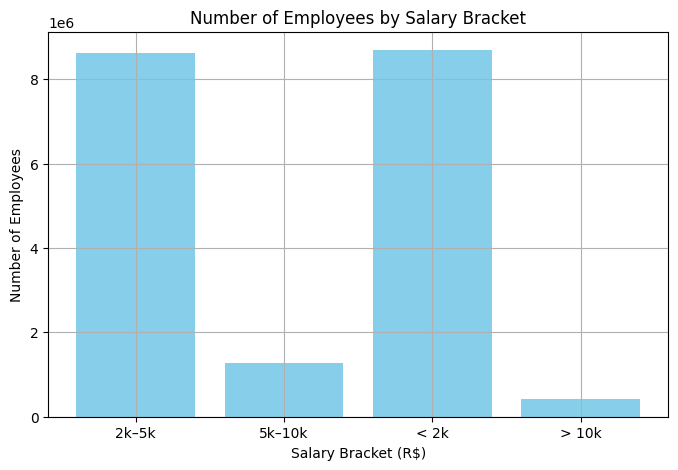

In [17]:
# Convert salary bracket count to Pandas to be easier to manage with Matplotlib
salary_brackets = combined_df.groupBy("SALARY_BRACKET").count().orderBy("SALARY_BRACKET")
brackets_pd = salary_brackets.toPandas()

# Plot
plt.figure(figsize=(8,5))
plt.bar(brackets_pd["SALARY_BRACKET"], brackets_pd["count"], color='skyblue')
plt.title("Number of Employees by Salary Bracket")
plt.xlabel("Salary Bracket (R$)")
plt.ylabel("Number of Employees")
plt.grid(True)
plt.show()

### 🥧 Pie Chart: Top 10 Departments by Total Net Salary Spending

This pie chart illustrates the distribution of total net salary spending across the top 10 departments.  
It helps visualize how salary expenditure is concentrated in specific public sectors such as education, health, and public security.

- The larger the slice, the higher the total salary spending in that department.
- This chart is based on the `NET_TOTAL` column, which reflects the actual amount received by employees after deductions.


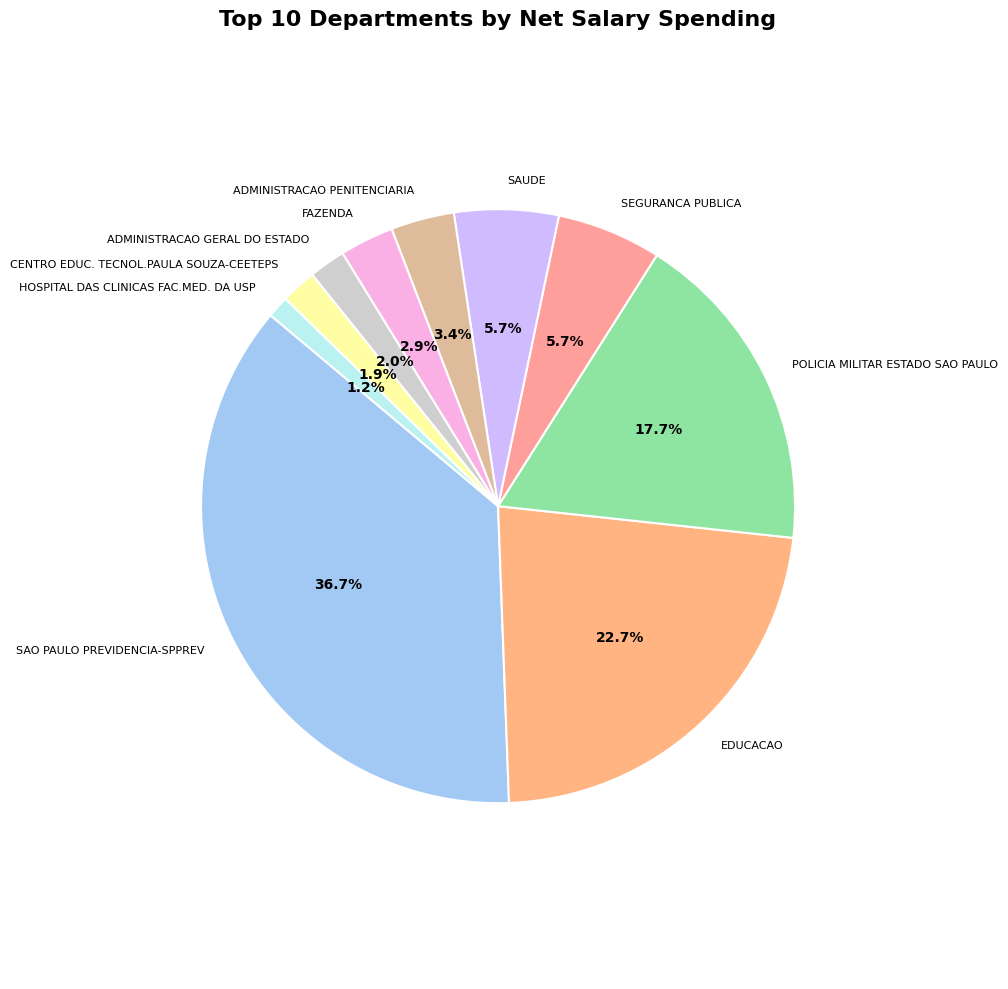

In [24]:
# This is used to change the visual style to mimic the design of ggplot2, look here for more information: https://matplotlib.org/stable/gallery/style_sheets/ggplot.html
plt.style.use("ggplot")

# Get color palette from seaborn, go over to this link to learn more: https://seaborn.pydata.org/tutorial/color_palettes.html
colors = sns.color_palette("pastel")[0:10]

# Convert to Pandas so we can have better control over the Tables
top_departments = combined_df.groupBy("DEPARTMENT") \
    .agg(sum("NET_TOTAL").alias("total_net_spending")) \
    .orderBy(col("total_net_spending").desc()) \
    .limit(10) \
    .toPandas()
# limiting to 10 so the pandas don't get overwhelmed by a lot of data

# Plot pie chart
fig, ax = plt.subplots(figsize=(10, 10))
wedges, texts, autotexts = ax.pie(
    top_departments["total_net_spending"],
    labels=top_departments["DEPARTMENT"],
    autopct='%1.1f%%',
    # styling properties, this startangle is just to define the starting angle of the pie chart, which is by default set to the right
    startangle=140,
    colors=colors,
    wedgeprops={"edgecolor": "white", "linewidth": 1.5},
    textprops={"fontsize": 8}
)

# Customize appearance
plt.setp(autotexts, size=10, weight="bold", color="black")
ax.set_title("Top 10 Departments by Net Salary Spending", fontsize=16, weight='bold')
ax.axis("equal")

plt.tight_layout()
plt.show()